In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
import keras_genomics
from keras_genomics.layers.convolutional import RevCompConv1D
import keras
import keras.layers as kl
from keras import backend as K 
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
from seqdataloader.batchproducers import coordbased
from seqdataloader.batchproducers.coordbased import coordstovals
from seqdataloader.batchproducers.coordbased import coordbatchproducers
from seqdataloader.batchproducers.coordbased import coordbatchtransformers
from keras.models import load_model
from keras.utils import CustomObjectScope
import json
import gzip
import codecs
from matplotlib import pyplot as plt
from scipy.stats import spearmanr, pearsonr, gaussian_kde
from sklearn.linear_model import LinearRegression
%matplotlib inline

Using TensorFlow backend.
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/users/amr1/mi

In [3]:
fastapath = "data/genome/saccer/sacCer3.genome.fa"
GenomeDict={}
sequence=''
inputdatafile = open(fastapath)
for line in inputdatafile:
    if line[0]=='>':
        if sequence != '':
            GenomeDict[chrm] = ''.join(sequence)
        chrm = line.strip().split('>')[1]
        sequence=[]
        Keep=False
        continue
    else:
        sequence.append(line.strip())
GenomeDict[chrm] = ''.join(sequence)

seq_len = 546
out_pred_len = 200
test_chrms = ["chrX", "chrXI"]
peaks = []
bedfile = "data/cbf1_pbexo/cbf1.pbexo.bed"
with open(bedfile) as inp:
    for line in inp:
        chrm = line.strip().split('\t')[0]
        if chrm not in test_chrms:
            continue
        pStart = int(line.strip().split('\t')[1])
        summit = pStart + 1
        start = int(summit - (seq_len/2))
        end = int(summit + (seq_len/2))
        if len(GenomeDict[chrm][start:end].upper()) == seq_len:
            peaks.append(GenomeDict[chrm][start:end].upper())

In [4]:
from deeplift.dinuc_shuffle import dinuc_shuffle

def fill_into_center(seq, insert):
    start = int((len(seq)/2.0)-(len(insert)/2.0))
    new_seq = seq[:start]+insert+seq[start+len(insert):]
    return new_seq

ltrdict = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1],
           'n':[0,0,0,0],'A':[1,0,0,0],'C':[0,1,0,0],'G':[0,0,1,0],
           'T':[0,0,0,1],'N':[0,0,0,0]}
def getOneHot(ISM_sequences):
  # takes in list of sequences
    one_hot_seqs = []
    for seq in ISM_sequences:
        one_hot = []
        for i in range(len(seq)):
            one_hot.append(ltrdict[seq[i:i+1]])
        one_hot_seqs.append(one_hot)
    return np.array(one_hot_seqs)

def multinomial_nll(true_counts, logits):
    """Compute the multinomial negative log-likelihood
    Args:
      true_counts: observed count values
      logits: predicted logit values
    """
    counts_per_example = tf.reduce_sum(true_counts, axis=-1)
    dist = tfp.distributions.Multinomial(total_count=counts_per_example,
                                         logits=logits)
    return (-tf.reduce_sum(dist.log_prob(true_counts)) / 
            tf.to_float(tf.shape(true_counts)[0]))

#from https://github.com/kundajelab/basepair/blob/cda0875571066343cdf90aed031f7c51714d991a/basepair/losses.py#L87
class MultichannelMultinomialNLL(object):
    def __init__(self, n):
        self.__name__ = "MultichannelMultinomialNLL"
        self.n = n

    def __call__(self, true_counts, logits):
        for i in range(self.n):
            loss = multinomial_nll(true_counts[..., i], logits[..., i])
            if i == 0:
                total = loss
            else:
                total += loss
        return total

    def get_config(self):
        return {"n": self.n}

In [5]:
def generate_matrix(seq):
    seq_matrix = np.zeros((4, len(seq)))
    for j in range(len(seq)):
        if seq[j] == 'A':
            seq_matrix[0,j] = 1
        elif seq[j] == 'C':
            seq_matrix[1,j] = 1
        elif seq[j] == 'G':
            seq_matrix[2,j] = 1
        elif seq[j] == 'T':
            seq_matrix[3,j] = 1
    return seq_matrix
def get_PSAM_score(sequence, score_matrix):
    score = 0
    score_len = score_matrix.shape[0]
    for j in range(len(sequence) - score_len + 1):
        seq_matrix = generate_matrix(sequence[j:j+score_len])
        diagonal = np.diagonal(np.matmul(score_matrix,seq_matrix))
        score += np.prod(diagonal)
    return score
def get_PWM_score(sequence, score_matrix):
    score = 0
    score_len = score_matrix.shape[0]
    for j in range(len(sequence) - score_len + 1):
        seq_matrix = generate_matrix(sequence[j:j+score_len])
        diagonal = np.diagonal(np.matmul(score_matrix,seq_matrix))
        score = np.maximum(score, np.sum(diagonal))
    return score

def ddG(Kd1, Kd2, R=1.9872036e-3, T=295):
    return R*T*np.log(Kd2/Kd1)

In [6]:
# lines = []
# with open('/Users/connor/Documents/fordycelab/Maerkl_Quake_data/PHO4_PSAM_MaerklQuake2007.csv') as handle:
#     reader = csv.reader(handle)
#     for row in reader:
#         lines.append(row)
# Pho4_PSAM = np.array(lines)[1:,1:].T.astype('float')

In [7]:
!cat data/experimental/PSAMs/PHO4_PSAM_MaerklQuake2007.csv

,1,2,3,4,5,6,7,8
A,0.427936657,0.025716282,1,0.000989072,0.004118616,0.004848852,0.001591478,0.115689085
C,0.392744657,1,0.002482328,1,0.005513065,0.010717629,0.186859366,1
G,1,0.186859366,0.010717629,0.005513065,1,0.002482328,1,0.392744657
T,0.115689085,0.001591478,0.004848852,0.004118616,0.000989072,1,0.025716282,0.427936657

In [8]:
import csv
import numpy as np

lines = []
with open('data/experimental/PSAMs/PHO4_PSAM_MaerklQuake2007.csv') as handle:
    reader = csv.reader(handle)
    for row in reader:
        lines.append(row)
PHO4_PSAM = np.array(lines)[1:,1:].T.astype('float')

In [9]:
PHO4_PSAM

array([[4.27936657e-01, 3.92744657e-01, 1.00000000e+00, 1.15689085e-01],
       [2.57162820e-02, 1.00000000e+00, 1.86859366e-01, 1.59147800e-03],
       [1.00000000e+00, 2.48232800e-03, 1.07176290e-02, 4.84885200e-03],
       [9.89072000e-04, 1.00000000e+00, 5.51306500e-03, 4.11861600e-03],
       [4.11861600e-03, 5.51306500e-03, 1.00000000e+00, 9.89072000e-04],
       [4.84885200e-03, 1.07176290e-02, 2.48232800e-03, 1.00000000e+00],
       [1.59147800e-03, 1.86859366e-01, 1.00000000e+00, 2.57162820e-02],
       [1.15689085e-01, 1.00000000e+00, 3.92744657e-01, 4.27936657e-01]])

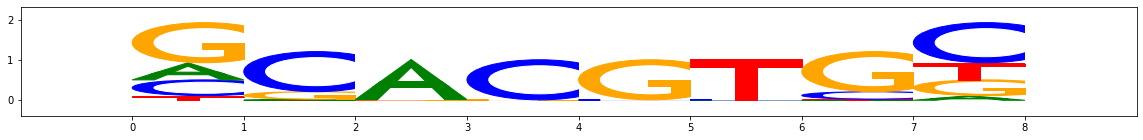

In [10]:
import matplotlib
from deeplift.visualization import viz_sequence
%matplotlib inline

viz_sequence.plot_weights(PHO4_PSAM)

In [11]:
PHO4_ddG = [[-ddG(x,1) for x in j] for j in PHO4_PSAM]
PHO4_ddG = np.array([i-np.mean(i) for i in PHO4_ddG])

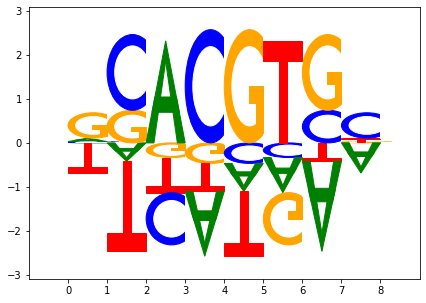

In [12]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
viz_sequence.plot_weights_given_ax(ax, PHO4_ddG,
                                    height_padding_factor=0.2,
                                    length_padding=1.0,
                                    subticks_frequency=1.0,
                                    highlight={})

In [13]:
get_PSAM_score("TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT", PHO4_PSAM)

9.605281005511455e-13

In [14]:
get_PSAM_score("TTTTTTTTTTTTTTTT", PHO4_PSAM)

3.601980377066797e-13

In [15]:
get_PSAM_score("TTTTTTTTTACACCTTGTTTTTTTTT", PHO4_PSAM)

2.3925773312813408e-05

In [16]:
get_PSAM_score("TTGCACGTGCTT", PHO4_PSAM)

1.0000000022653133

In [17]:
get_PSAM_score("GCACGTGC", PHO4_PSAM)

1.0

In [18]:
get_PSAM_score("AAAAACACGTGAAAAA", PHO4_PSAM)

0.04950780820742313

In [19]:
R=1.9872036e-3
T=295
R*T*np.log(get_PSAM_score("GCACGTGC", PHO4_PSAM))

0.0

In [20]:
consensus = "AAAAACACGTGAAAAA"

In [21]:
seqs = []

def create_seqs(pos, curr_seq):
    if pos  == 5:
        seqs.append("".join(curr_seq)+"CACGTGAAAAA")
        return
    for cx in ['A', 'C', 'G', 'T']:
        curr_seq[pos] = cx
        create_seqs(pos+1, curr_seq)

create_seqs(0, list("AAAAA"))
seqs = list(set(seqs))

In [22]:
len(seqs)

1024

In [23]:
with CustomObjectScope({'MultichannelMultinomialNLL': MultichannelMultinomialNLL,'RevCompConv1D': RevCompConv1D}):
    model = load_model("data/models/cbf1_pbexo_model.h5")







Instructions for updating:
Use `tf.cast` instead.


In [24]:
seqToPho4Ddg = {}
firstLine = True
with open("data/experimental/all_predicted_ddGs.csv") as inp:
    for line in inp:
        if firstLine:
            firstLine = False
            continue
        flank, Cbf1_ddg, Pho4_ddg = line.strip().split(',')
        seqToPho4Ddg[flank[:5]+"CACGTG"+flank[5:]] = float(Cbf1_ddg)

In [25]:
building_blocks = []
for idx in range(5):
    for cx in ['C', 'G', 'T']:
        new_seq = list(consensus)
        new_seq[idx] = cx
        building_blocks.append("".join(new_seq))
    
num_samples = 100
buildingBlocksToDeltaLogCount = {}
for curr_seq in building_blocks:
    pre_seqs = []
    post_seqs = []
    indices = np.random.choice(len(peaks), num_samples, replace=False)
    for idx in indices:
        base_seq = dinuc_shuffle(peaks[idx])
        pre_seq = fill_into_center(base_seq, consensus)
        post_seq = fill_into_center(base_seq, curr_seq)
        pre_seqs.append(pre_seq)
        post_seqs.append(post_seq)
    pre = model.predict([getOneHot(pre_seqs), np.zeros((num_samples,)), np.zeros((num_samples,out_pred_len,2))])
    post = model.predict([getOneHot(post_seqs), np.zeros((num_samples,)), np.zeros((num_samples,out_pred_len,2))])
    buildingBlocksToDeltaLogCount[curr_seq] = np.mean(post[0]-pre[0])

In [26]:
obj_text = codecs.open("data/preds/pbexo.cbf1.flankToDeltaLogCount.json", 'r', encoding='utf-8').read()
flankToCountPreds = json.loads(obj_text)

In [27]:
seqToDeltaLogCount = {}
seqToPSAMScore = {}
for curr_seq in seqs:
    key = curr_seq[:5]+"AAAAA"
    y_0 = np.array(flankToCountPreds[key][0]).astype(float)
    y_1 = np.array(flankToCountPreds[key][1]).astype(float)
    seqToDeltaLogCount[curr_seq] = np.mean(y_1-y_0)
    seqToPSAMScore[curr_seq] = R*T*np.log(get_PSAM_score(curr_seq, PHO4_PSAM))

In [28]:
buildingBlocksToDdG = {}
for curr_seq in building_blocks:
    buildingBlocksToDdG[curr_seq] = seqToPho4Ddg[curr_seq] - seqToPho4Ddg[consensus]

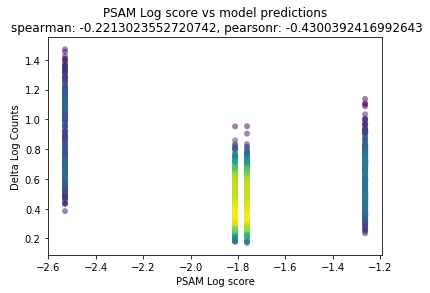

In [29]:
xvals = []
yvals = []

for seq in seqs:
    xvals.append(seqToPSAMScore[seq])
    yvals.append(seqToDeltaLogCount[seq])

xy = np.vstack([xvals,yvals])
z = gaussian_kde(xy)(xy)
smallFont = {'size' : 10}
plt.rc('font', **smallFont)
fig, ax = plt.subplots()
ax.scatter(xvals, yvals, c=z, edgecolor='', alpha=0.5)
plt.xlabel("PSAM Log score")
plt.ylabel("Delta Log Counts")
plt.title("PSAM Log score vs model predictions\n spearman: "+str(spearmanr(xvals, yvals)[0])+", pearsonr: "+str(pearsonr(xvals,yvals)[0]))
plt.show()

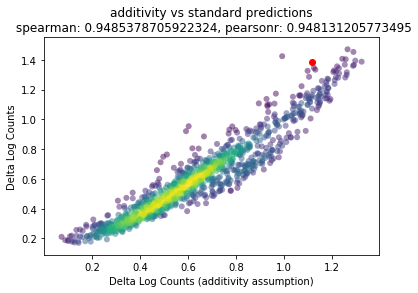

In [30]:
xvals = []
yvals = []

for seq in seqs:
    score = seqToDeltaLogCount[consensus]
    for idx in range(len(consensus)):
        if consensus[idx] != seq[idx]:
            new_seq = list(consensus)
            new_seq[idx] = seq[idx]
            to_score = "".join(new_seq)
            score += buildingBlocksToDeltaLogCount[to_score]
    xvals.append(score)
    yvals.append(seqToDeltaLogCount[seq])

xy = np.vstack([xvals,yvals])
z = gaussian_kde(xy)(xy)
smallFont = {'size' : 10}
plt.rc('font', **smallFont)
fig, ax = plt.subplots()
ax.scatter(xvals, yvals, c=z, edgecolor='', alpha=0.5)
plt.plot(1.1190233343839644, 1.387264679968357,'ro')
plt.xlabel("Delta Log Counts (additivity assumption)")
plt.ylabel("Delta Log Counts")
plt.title("additivity vs standard predictions\n spearman: "+str(spearmanr(xvals, yvals)[0])+", pearsonr: "+str(pearsonr(xvals,yvals)[0]))
plt.show()

In [31]:
for idx, seq in enumerate(seqs):
    if seq == "CCCCCCACGTGAAAAA":
        print(seq, xvals[idx], yvals[idx])

CCCCCCACGTGAAAAA 0.3237514346092939 0.2571984404325485


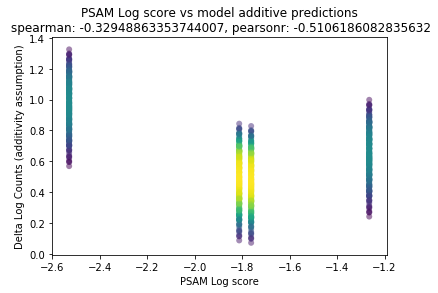

In [32]:
xvals = []
yvals = []

for seq in seqs:
    score = seqToDeltaLogCount[consensus]
    for idx in range(len(consensus)):
        if consensus[idx] != seq[idx]:
            new_seq = list(consensus)
            new_seq[idx] = seq[idx]
            to_score = "".join(new_seq)
            score += buildingBlocksToDeltaLogCount[to_score]
    yvals.append(score)
    xvals.append(seqToPSAMScore[seq])

xy = np.vstack([xvals,yvals])
z = gaussian_kde(xy)(xy)
smallFont = {'size' : 10}
plt.rc('font', **smallFont)
fig, ax = plt.subplots()
ax.scatter(xvals, yvals, c=z, edgecolor='', alpha=0.5)
plt.xlabel("PSAM Log score")
plt.ylabel("Delta Log Counts (additivity assumption)")
plt.title("PSAM Log score vs model additive predictions\n spearman: "+str(spearmanr(xvals, yvals)[0])+", pearsonr: "+str(pearsonr(xvals,yvals)[0]))
plt.show()

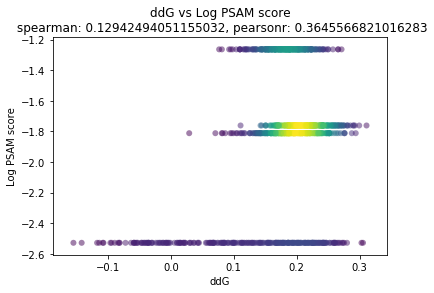

In [33]:
xvals = []
yvals = []

for seq in seqs:
    yvals.append(seqToPSAMScore[seq])
    xvals.append(seqToPho4Ddg[seq])
    
xy = np.vstack([xvals,yvals])
z = gaussian_kde(xy)(xy)
smallFont = {'size' : 10}
plt.rc('font', **smallFont)
fig, ax = plt.subplots()
ax.scatter(xvals, yvals, c=z, edgecolor='', alpha=0.5)
plt.xlabel("ddG")
plt.ylabel("Log PSAM score")
plt.title("ddG vs Log PSAM score\n spearman: "+str(spearmanr(xvals, yvals)[0])+", pearsonr: "+str(pearsonr(xvals,yvals)[0]))
plt.show()

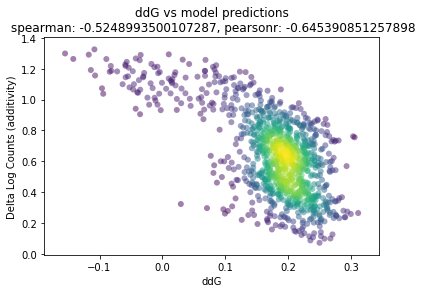

In [34]:
xvals = []
yvals = []

for seq in seqs:
    xvals.append(seqToPho4Ddg[seq])
    score = seqToDeltaLogCount[consensus]
    for idx in range(len(consensus)):
        if consensus[idx] != seq[idx]:
            new_seq = list(consensus)
            new_seq[idx] = seq[idx]
            to_score = "".join(new_seq)
            score += buildingBlocksToDeltaLogCount[to_score]
    yvals.append(score)

xy = np.vstack([xvals,yvals])
z = gaussian_kde(xy)(xy)
smallFont = {'size' : 10}
plt.rc('font', **smallFont)
fig, ax = plt.subplots()
ax.scatter(xvals, yvals, c=z, edgecolor='', alpha=0.5)
plt.xlabel("ddG")
plt.ylabel("Delta Log Counts (additivity)")
plt.title("ddG vs model predictions\n spearman: "+str(spearmanr(xvals, yvals)[0])+", pearsonr: "+str(pearsonr(xvals,yvals)[0]))
plt.show()

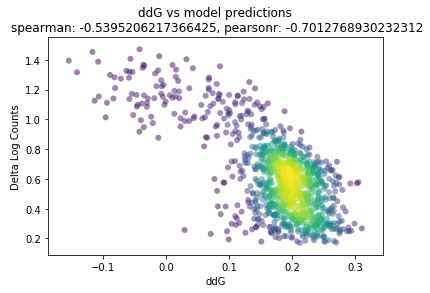

In [35]:
xvals = []
yvals = []

for seq in seqs:
    yvals.append(seqToDeltaLogCount[seq])
    xvals.append(seqToPho4Ddg[seq])

xy = np.vstack([xvals,yvals])
z = gaussian_kde(xy)(xy)
smallFont = {'size' : 10}
plt.rc('font', **smallFont)
fig, ax = plt.subplots()
ax.scatter(xvals, yvals, c=z, edgecolor='', alpha=0.5)
plt.xlabel("ddG")
plt.ylabel("Delta Log Counts")
plt.title("ddG vs model predictions\n spearman: "+str(spearmanr(xvals, yvals)[0])+", pearsonr: "+str(pearsonr(xvals,yvals)[0]))
plt.show()

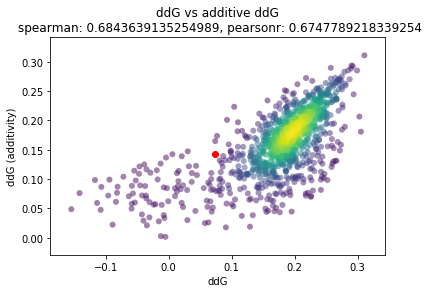

In [36]:
xvals = []
yvals = []

for seq in seqs:
    xvals.append(seqToPho4Ddg[seq])
    score = seqToPho4Ddg[consensus]
    for idx in range(len(consensus)):
        if consensus[idx] != seq[idx]:
            new_seq = list(consensus)
            new_seq[idx] = seq[idx]
            to_score = "".join(new_seq)
            score += buildingBlocksToDdG[to_score]
    yvals.append(score)

xy = np.vstack([xvals,yvals])
z = gaussian_kde(xy)(xy)
smallFont = {'size' : 10}
plt.rc('font', **smallFont)
fig, ax = plt.subplots()
ax.scatter(xvals, yvals, c=z, edgecolor='', alpha=0.5)
plt.plot(0.07332783071269328,0.14194742469062144,'ro')
plt.xlabel("ddG")
plt.ylabel("ddG (additivity)")
plt.title("ddG vs additive ddG\n spearman: "+str(spearmanr(xvals, yvals)[0])+", pearsonr: "+str(pearsonr(xvals,yvals)[0]))
plt.show()

In [37]:
for idx, seq in enumerate(seqs):
    if xvals[idx] < 0.09:
        print(seq, xvals[idx], yvals[idx])

GTGATCACGTGAAAAA -0.042350590414582 0.07200639676374365
CCCACCACGTGAAAAA 0.08092889916223456 0.08861020933908392
GGAATCACGTGAAAAA 0.0857573671273606 0.12096165847104956
AAGGTCACGTGAAAAA -0.012876670993147599 0.12631612252515723
TCGGTCACGTGAAAAA -0.05900015700536798 0.04953553509038855
TTCATCACGTGAAAAA 0.0787390543155091 0.0797940714291947
GTTATCACGTGAAAAA 0.055600017123641265 0.08451228570264746
TTGATCACGTGAAAAA -0.017562223783908593 0.09933518599790503
AGGATCACGTGAAAAA 0.0898319406442063 0.13230692576688696
CCCATCACGTGAAAAA 0.05748294275325705 0.024926416390361084
TAGGTCACGTGAAAAA -0.07196884620863031 0.10398014616292883
CTTATCACGTGAAAAA 0.08480498921197821 0.08336829375547339
GCCGTCACGTGAAAAA -0.012502338922796952 0.0026656312875168453
CTGATCACGTGAAAAA 0.01001403462213446 0.07086240481656958
GAGGTCACGTGAAAAA -0.08207318205314706 0.07665135692876746
TAAGTCACGTGAAAAA 0.005800764822186721 0.1422996444634812
TGTGTCACGTGAAAAA -0.0941038133569343 0.09907206129354407
TGCGTCACGTGAAAAA -0.035